## Import Necessary Packages

In [236]:
import os
import torch
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import proplot as pplt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader
warnings.filterwarnings('ignore')

## Functions

In [237]:
def load(varname):
    data = xr.open_dataset('/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/processed/LR_ERA5_IMERG_pr_bl_terms.nc')
    return data[varname].load()

def log_normalize(data,c=1.0):
    '''Logarithmic normalization: X' = ln(X+c), where X is the precipitation data, and c is a constant to handle 0 values'''
    normdata = np.log(data+c)
    return normdata

def inverse_log_normalize(normdata,c=1.0):
    data = np.exp(normdata)-c
    return data

def prepare(inputs,target,testsize):
    inputs   = [inputs] if not isinstance(inputs,list) else inputs
    combined = xr.merge([*inputs,target])
    df = combined.to_dataframe().reset_index()
    df = df.sort_values('time')
    x  = df[[i.name for i in inputs]]
    y  = df[[target.name]]
    xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=testsize,shuffle=False)
    return xtrain,xtest,ytrain,ytest

## Load Data

In [238]:
bl  = load('bl')
pr  = load('pr')
prlog = log_normalize(pr,c=1.0)

## Exploratory Plots

In [353]:
x    = bl.values.flatten()
y    = pr.values.flatten()
ylog = prlog.values.flatten()
bins = 100

Locator attempting to generate 10000 ticks ([1.0, ..., 10000.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 10000 ticks ([1.0, ..., 10000.0]), which exceeds Locator.MAXTICKS (1000).


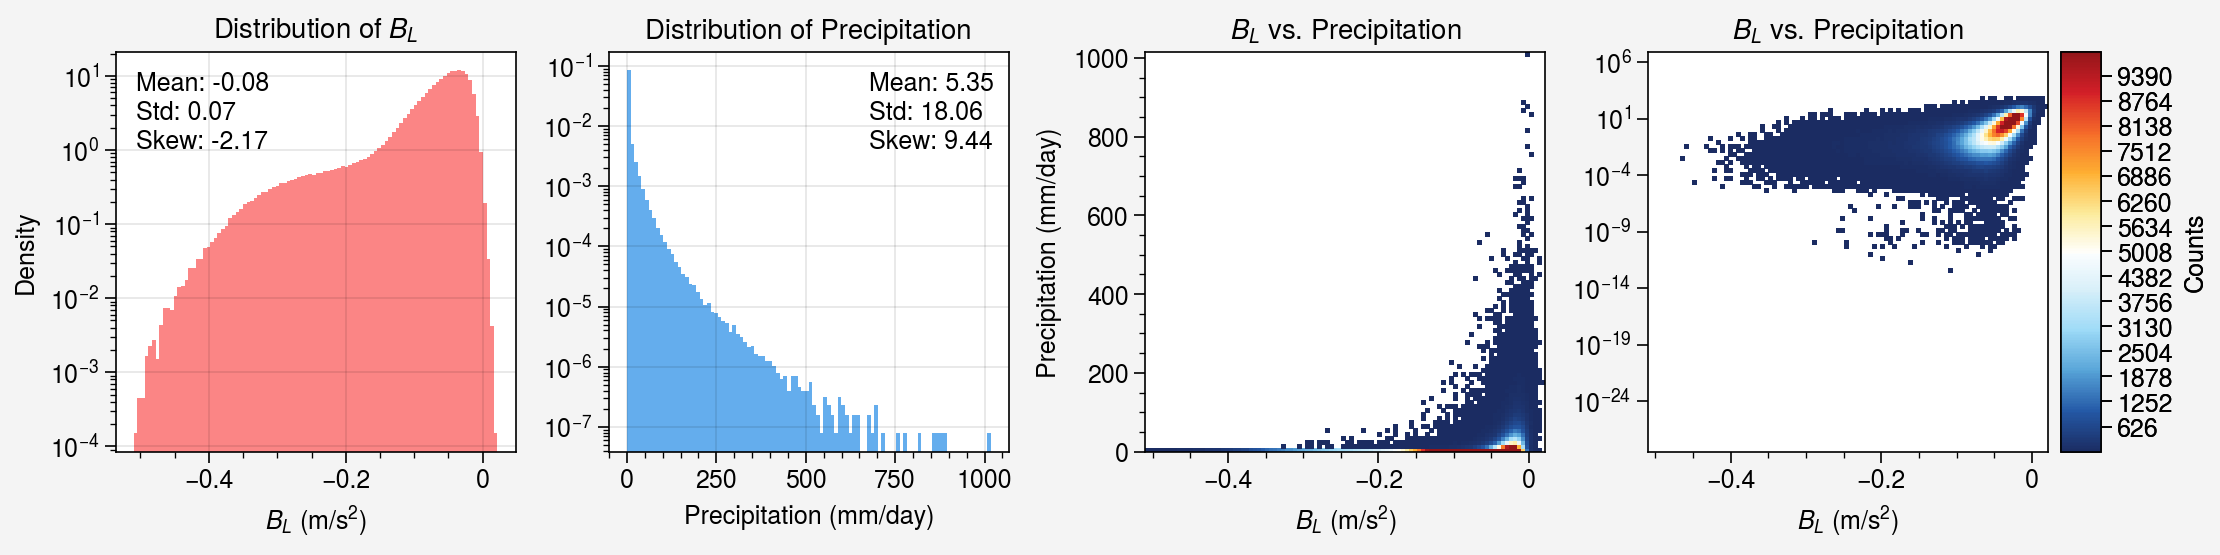

In [354]:
fig,axs = pplt.subplots(nrows=1,ncols=4,refwidth=2,share=False)
axs[0].format(title='Distribution of $\mathit{B_L}$',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Density',yscale='log',yformatter='log')
axs[1].format(title='Distribution of Precipitation',xlabel='Precipitation (mm/day)',yscale='log',yformatter='log')
axs[2].format(title='$\mathit{B_L}$ vs. Precipitation',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Precipitation (mm/day)')
axs[3].format(title='$\mathit{B_L}$ vs. Precipitation',xlabel='$\mathit{B_L}$ (m/s$^2$)',yscale='log',yformatter='log')

axs[0].hist(x,bins=bins,density=True,color='red6',alpha=0.7)
axs[1].hist(y,bins=bins,density=True,color='blue6',alpha=0.7)
statsx = f'Mean: {np.mean(x):.2f}\nStd: {np.std(x):.2f}\nSkew: {stats.skew(x):.2f}'
statsy = f'Mean: {np.mean(y):.2f}\nStd: {np.std(y):.2f}\nSkew: {stats.skew(y):.2f}'
axs[0].text(0.05,0.95,statsx,transform=axs[0].transAxes,va='top')
axs[1].text(0.65,0.95,statsy,transform=axs[1].transAxes,va='top')

hist,xedges,yedges = np.histogram2d(x,y,bins=(bins,bins))
maskedhist = np.ma.masked_where(hist==0,hist)
mesh = axs[2].pcolormesh(xedges,yedges,maskedhist.T,cmap='ColdHot',vmax=10000,levels=10000)

xedgeslin = np.linspace(np.min(x),np.max(x),bins+1)
yedgeslog = np.logspace(np.log(np.min(y[y>0])),np.log(np.max(y)),bins+1)
histlog,_,_ = np.histogram2d(x,y,bins=(xedgeslin,yedgeslog))
maskedhistlog = np.ma.masked_where(histlog==0,histlog)
meshlog = axs[3].pcolormesh(xedgeslin,yedgeslog,maskedhistlog.T,cmap='ColdHot',vmax=10000,levels=10000)

axs[3].colorbar(meshlog,label='Counts')

pplt.show()

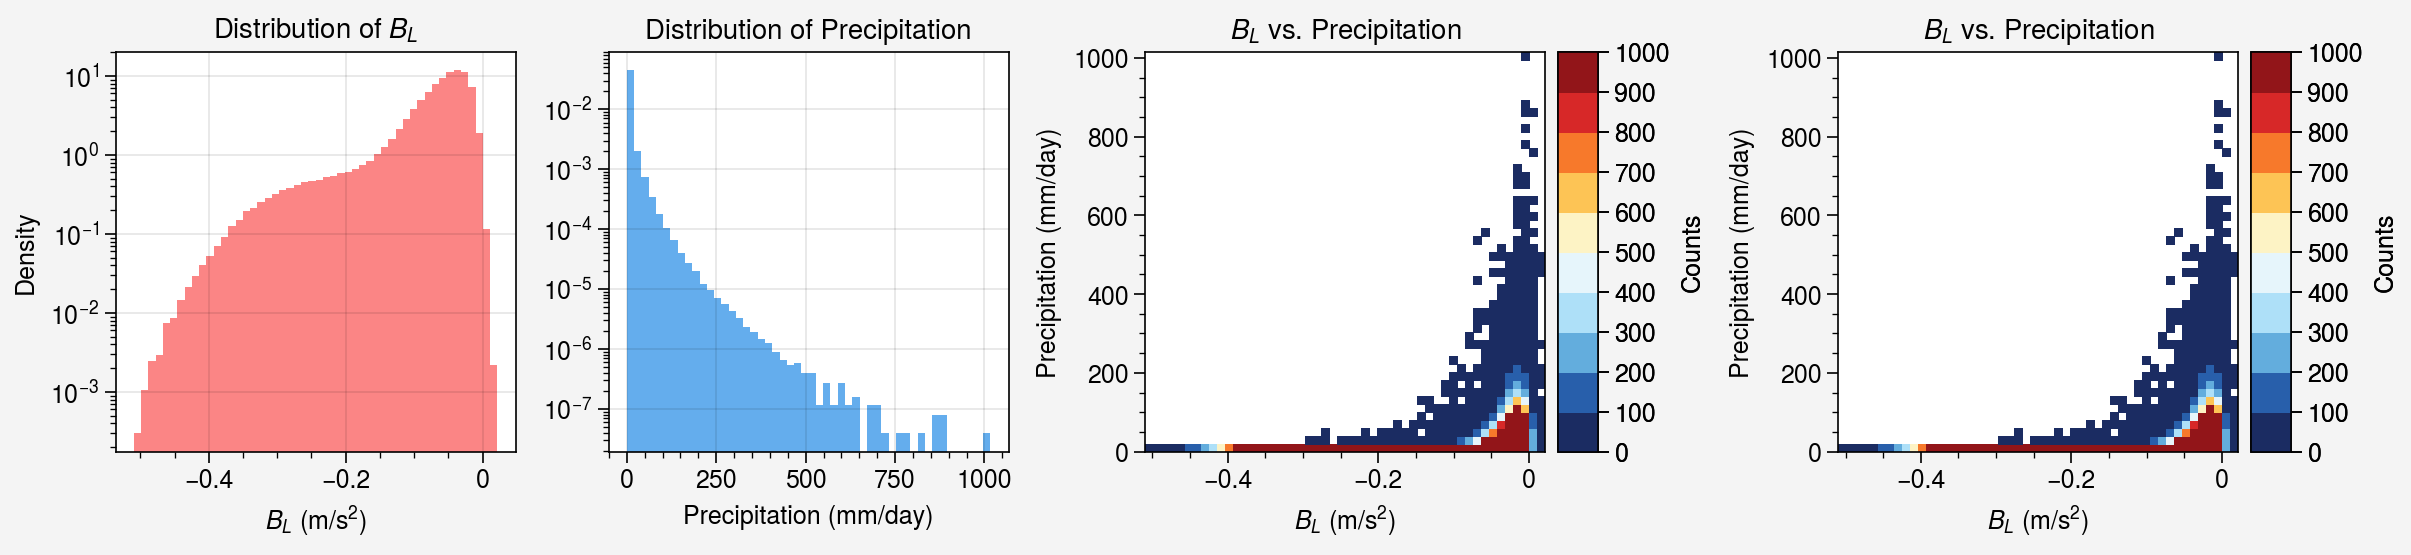

In [331]:
bins = 50


fig,axs = pplt.subplots(nrows=1,ncols=4,refwidth=2,share=False)
axs[0].format(title='Distribution of $\mathit{B_L}$',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Density',yscale='log',yformatter='log')
axs[1].format(title='Distribution of Precipitation',xlabel='Precipitation (mm/day)',yscale='log',yformatter='log')
axs[2].format(title='$\mathit{B_L}$ vs. Precipitation',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Precipitation (mm/day)')
axs[3].format(title='$\mathit{B_L}$ vs. Precipitation',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Precipitation (mm/day)',
              # yscale='log',yformatter='log'
             )

axs[0].hist(x,bins=bins,density=True,color='red6',alpha=0.7)
axs[1].hist(y,bins=bins,density=True,color='blue6',alpha=0.7)

hist,xedges,yedges = np.histogram2d(x,y,bins=(bins,bins))
maskedhist = np.ma.masked_where(hist==0,hist)
mesh = axs[2].pcolormesh(xedges,yedges,maskedhist.T,cmap='ColdHot',vmax=1000)
axs[2].colorbar(mesh,label='Counts')

mesh = axs[3].pcolormesh(xedges,yedges,maskedhist.T,cmap='ColdHot',vmax=1000)
axs[3].colorbar(mesh,label='Counts')

statsx = f'Mean: {np.mean(x):.2f}\nStd: {np.std(x):.2f}\nSkew: {stats.skew(x):.2f}'
statsy = f'Mean: {np.mean(y):.2f}\nStd: {np.std(y):.2f}\nSkew: {stats.skew(y):.2f}'
axs[0].text(0.05,0.95,statsx,transform=axs[0].transAxes,va='top')
axs[1].text(0.65,0.95,statsy,transform=axs[1].transAxes,va='top')
pplt.show()

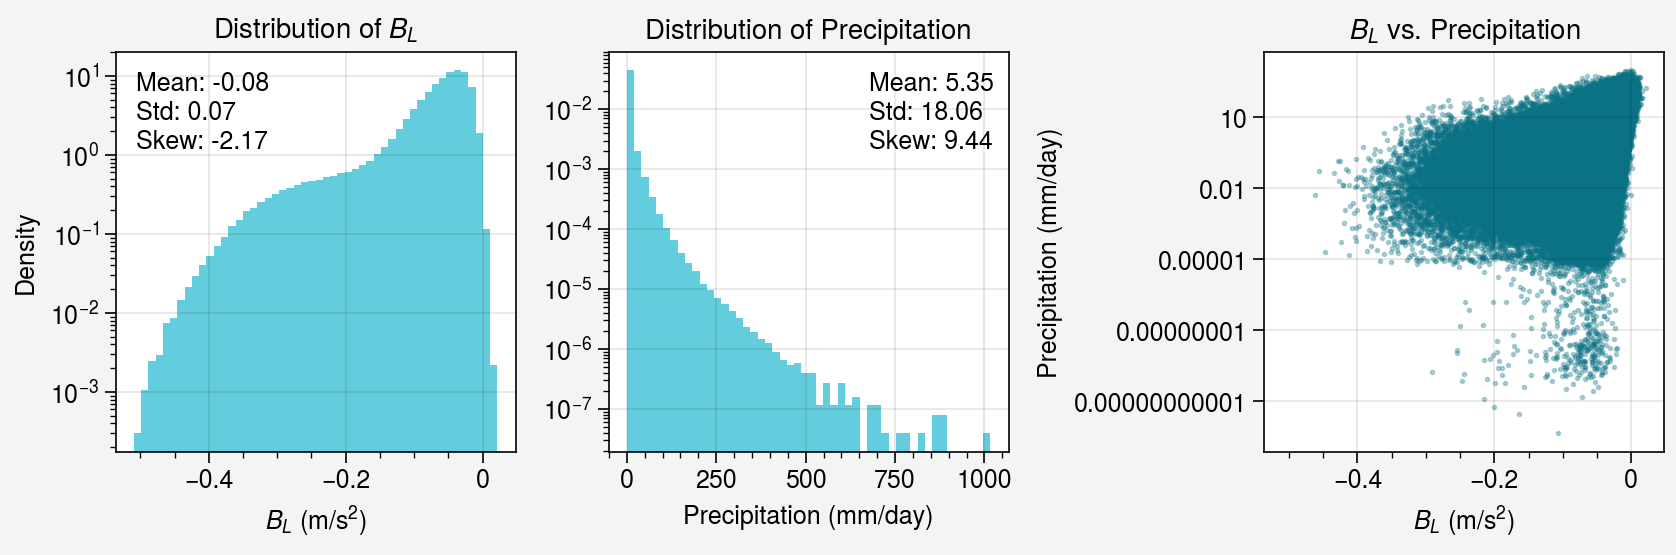

In [287]:
fig,axs = pplt.subplots(nrows=1,ncols=3,refwidth=2,share=False)
axs[0].format(title='Distribution of $\mathit{B_L}$',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Density',yscale='log',yformatter='log')
axs[1].format(title='Distribution of Precipitation',xlabel='Precipitation (mm/day)',yscale='log',yformatter='log')
axs[2].format(title='$\mathit{B_L}$ vs. Precipitation',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Precipitation (mm/day)',yscale='log')
axs[2].format(title='$\mathit{B_L}$ vs. Precipitation',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Precipitation (mm/day)',yscale='log')

axs[0].hist(x,bins=50,density=True,color='cyan5',alpha=0.7)
axs[1].hist(y,bins=50,density=True,color='cyan5',alpha=0.7)
axs[2].scatter(x,y,color='cyan9',marker='.',markersize=8,alpha=0.3)

statsx    = f'Mean: {np.mean(x):.2f}\nStd: {np.std(x):.2f}\nSkew: {stats.skew(x):.2f}'
statsy    = f'Mean: {np.mean(y):.2f}\nStd: {np.std(y):.2f}\nSkew: {stats.skew(y):.2f}'
axs[0].text(0.05,0.95,statsx,transform=axs[0].transAxes,va='top')
axs[1].text(0.65,0.95,statsy,transform=axs[1].transAxes,va='top')
pplt.show()

In [ ]:
fig,axs = pplt.subplots(nrows=1,ncols=3,refwidth=2,share=False)
axs[0].format(title='Distribution of $\mathit{B_L}$',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Density',yscale='log',yformatter='log')
axs[1].format(title='Distribution of Precipitation',xlabel='Precipitation (mm/day)',yscale='log',yformatter='log')
axs[2].format(title='Distribution of\nLog-Normalized Precipitation',xlabel='Log-Normalized Precipitation',yscale='log',yformatter='log')
axs[3].format(title='$\mathit{B_L}$ vs. Precipitation',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Precipitation (mm/day)')
# axs[4].format(title='$\mathit{B_L}$ vs. Log-Normalized\nPrecipitation',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Log-Normalized Precipitation')

axs[0].hist(x,bins=50,density=True,color='cyan5',alpha=0.7)
axs[1].hist(y,bins=50,density=True,color='cyan5',alpha=0.7)
axs[2].hist(ylog,bins=50,density=True,color='cyan5',alpha=0.7)
axs[3].scatter(x,y,color='cyan9',marker='.',markersize=8,alpha=0.3)
axs[4].scatter(x,ylog,color='cyan9',marker='.',markersize=8,alpha=0.3)

statsx    = f'Mean: {np.mean(x):.2f}\nStd: {np.std(x):.2f}\nSkew: {stats.skew(x):.2f}'
statsy    = f'Mean: {np.mean(y):.2f}\nStd: {np.std(y):.2f}\nSkew: {stats.skew(y):.2f}'
statsylog = f'Mean: {np.mean(ylog):.2f}\nStd: {np.std(ylog):.2f}\nSkew: {stats.skew(ylog):.2f}'
axs[0].text(0.05,0.95,statsx,transform=axs[0].transAxes,va='top')
axs[1].text(0.65,0.95,statsy,transform=axs[1].transAxes,va='top')
axs[2].text(0.65,0.95,statsylog,transform=axs[2].transAxes,va='top')
pplt.show()

## Split Data

In [240]:
xtrain,xtest,ytrain,ytest = prepare(inputs=[bl],target=pr,testsize=0.2)

ytrainlog = ytrain.apply(lambda v:log_normalize(v,c=1.0))
ytestlog  = ytest.apply(lambda v:log_normalize(v,c=1.0))

## Model Classes

In [241]:
class BASELINE:
    
    def __init__(self,binwidth,binmin,binmax,samplethresh,criterion):
        self.binwidth      = binwidth
        self.binmin        = binmin
        self.binmax        = binmax
        self.binedges      = np.arange(self.binmin,self.binmax+self.binwidth,self.binwidth)
        self.bincenters    = (self.binedges[:-1]+self.binedges[1:])/2
        self.nbins         = len(self.bincenters)
        self.samplethresh  = samplethresh
        self.model         = None
        self.criterion     = criterion

    def fit(self,inputs,targets):
        idxs  = np.digitize(inputs,self.binedges)-1
        Q0,Q1 = np.zeros(self.nbins),np.zeros(self.nbins)
        for i in range(targets.size):
            idx    = idxs[i]
            target = targets[i]
            if 0<=idx<self.nbins and np.isfinite(target):
                Q0[idx] += 1
                Q1[idx] += target
        with np.errstate(divide='ignore',invalid='ignore'):
            self.model = np.where(Q0>=self.samplethresh,Q1/Q0,np.nan)
        return (self.bincenters,self.model)

    def predict(self,inputs):
        binidxs = np.clip(np.digitize(inputs,self.binedges)-1,0,self.nbins-1)
        outputs = self.model[binidxs]
        outputs = np.maximum(outputs,0) # Enforce non-negative constraint
        return outputs
    
    def evaluate(self,outputs,targets):
        mask    = ~np.isnan(outputs)&~np.isnan(targets)
        outputs = torch.FloatTensor(outputs[mask])
        targets = torch.FloatTensor(targets[mask])
        loss    = self.criterion(outputs,targets).item()
        return loss

In [243]:
class MLPMODEL(torch.nn.Module):
    
    def __init__(self,inputsize,hiddensize,outputsize,nhiddenlayers,activation=None):
        super(MLPMODEL,self).__init__()    
        self.inputsize     = inputsize
        self.hiddensize    = hiddensize
        self.outputsize    = outputsize
        self.nhiddenlayers = nhiddenlayers
        self.activation    = activation if activation is not None else torch.nn.Identity()
        layers = []
        layers.append(torch.nn.Linear(inputsize,hiddensize))
        layers.append(self.activation)
        for _ in range(nhiddenlayers-1):
            layers.append(torch.nn.Linear(hiddensize,hiddensize))
            layers.append(self.activation)
        layers.append(torch.nn.Linear(hiddensize,outputsize))
        self.layers = torch.nn.Sequential(*layers)
    def forward(self,x):
        return self.layers(x)

class MLP:
    
    def __init__(self,inputsize,hiddensize,outputsize,nhiddenlayers,activation,
                 criterion,learningrate,nepochs,batchsize,validsplit,patience,randomstate):
        self.model       = MLPMODEL(inputsize,hiddensize,outputsize,nhiddenlayers,activation)
        self.criterion   = criterion
        self.optimizer   = torch.optim.Adam(self.model.parameters(),lr=learningrate)
        self.nepochs     = nepochs
        self.batchsize   = batchsize
        self.validsplit  = validsplit
        self.patience    = patience
        self.randomstate = randomstate
        self.device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def _tensor(self,data):
        if isinstance(data,pd.DataFrame):
            return torch.FloatTensor(data.values)
        elif isinstance(data,pd.Series):
            return torch.FloatTensor(data.values.reshape(-1,1))
        elif isinstance(data,np.ndarray):
            if data.ndim==1:
                return torch.FloatTensor(data.reshape(-1,1))
            return data
        elif isinstance(data,list):
            return torch.FloatTensor(np.array(data).reshape(-1,1))
        else:
            raise ValueError('Unsupported data type. Please provide a pd.DataFrame, pd.Series, np.ndarray, or list.')   

    def fit(self,inputs,targets):
        inputs  = self._tensor(inputs)
        targets = self._tensor(targets)
        xtrain,xvalid,ytrain,yvalid = train_test_split(inputs,targets,test_size=self.validsplit,random_state=self.randomstate)
        traindataset = TensorDataset(xtrain,ytrain)
        validdataset = TensorDataset(xvalid,yvalid)
        trainloader  = DataLoader(traindataset,batch_size=self.batchsize,shuffle=True)
        validloader  = DataLoader(validdataset,batch_size=self.batchsize,shuffle=False)
        trainlosses = []
        validlosses = []
        bestvalidloss   = float('inf')
        patiencecounter = 0
        for epoch in range(self.nepochs):
            self.model.train()
            trainloss = 0.0
            for batchinputs,batchtargets in trainloader:
                self.optimizer.zero_grad()
                batchoutputs = self.model(batchinputs)
                batchloss    = self.criterion(batchoutputs,batchtargets)
                batchloss.backward()
                self.optimizer.step()
                trainloss += batchloss.item()*batchinputs.size(0)
            trainloss /= len(trainloader.dataset)
            trainlosses.append(trainloss) 
            self.model.eval()
            validloss = 0.0
            with torch.no_grad():
                for batchinputs,batchtargets in validloader:
                    batchoutputs = self.model(batchinputs)
                    batchloss    = self.criterion(batchoutputs,batchtargets)
                    validloss   += batchloss.item()*batchinputs.size(0)
            validloss /= len(validloader.dataset)
            validlosses.append(validloss)
            print(f'Epoch {epoch+1}/{self.nepochs} - Training Loss: {trainloss:.4f}, Validation Loss: {validloss:.4f}')
            if validloss<bestvalidloss:
                bestvalidloss   = validloss
                patiencecounter = 0
                torch.save(self.model.state_dict(),'best_model.pth')
            else:
                patiencecounter += 1
                if patiencecounter>=self.patience:
                    print(f'Early stopping triggered after {epoch+1} epochs!')
                    self.model.load_state_dict(torch.load('best_model.pth'))
                    break
        return (trainlosses,validlosses)

    def predict(self,inputs):
        inputs  = self._tensor(inputs).to(self.device)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(inputs)
        return outputs.cpu().numpy()

    def evaluate(self,inputs,targets):
        inputs  = self._tensor(inputs).to(self.device)
        targets = self._tensor(targets).to(self.device)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(inputs)
            loss    = self.criterion(outputs,targets).item()
        return loss

## Train Regular MLPs

In [190]:
configs = [
    {'name':'linear_mse',
     'activation':torch.nn.Identity(),
     'criterion':torch.nn.MSELoss(),
     'description':'Linear MSE'},
    {'name':'linear_mae',
     'activation':torch.nn.Identity(), 
     'criterion':torch.nn.L1Loss(),    
     'description':'Linear MAE'},
    {'name':'relu_mse',
     'activation':torch.nn.ReLU(),
     'criterion':torch.nn.MSELoss(),
     'description':'Nonlinear MSE'},
    {'name':'relu_mae',
     'activation':torch.nn.ReLU(),
     'criterion':torch.nn.L1Loss(),
     'description':'Nonlinear MAE'}]

trainedmodels = {}
results       = {}
for config in configs:
    print(f"\n{'='*60}")
    print(f"Training {config['description']}")
    print(f"{'='*60}")
    mlp = MLP(
        inputsize=xtrain.shape[1], 
        hiddensize=64, 
        outputsize=ytrain.shape[1], 
        nhiddenlayers=1,
        activation=config['activation'],
        criterion=config['criterion'],
        learningrate=0.001,
        nepochs=50,
        batchsize=500,
        validsplit=0.25,
        patience=2,
        randomstate=42)
    trainlosses,validlosses = mlp.fit(xtrain['bl'].values,ytrain['pr'].values)
    modelfilename = f'best_model_{config["name"]}.pth'
    torch.save(mlp.model.state_dict(),modelfilename)
    print(f"Model saved as: {modelfilename}")
    testoutputs = mlp.predict(xtest['bl'].values)
    testloss    = mlp.evaluate(xtest['bl'].values,ytest['pr'].values)
    trainedmodels[config['name']] = mlp
    results[config['name']] = {
        'trainlosses':trainlosses,
        'validlosses':validlosses,
        'testoutputs':testoutputs,
        'testloss':testloss,
        'modelfile':modelfilename,
        'description':config['description']}


Training Linear MSE
Epoch 1/50 - Training Loss: 327.6776, Validation Loss: 317.8302
Epoch 2/50 - Training Loss: 318.4223, Validation Loss: 317.6713
Epoch 3/50 - Training Loss: 318.4022, Validation Loss: 317.6237
Epoch 4/50 - Training Loss: 318.3976, Validation Loss: 317.6205
Epoch 5/50 - Training Loss: 318.3990, Validation Loss: 317.6771
Epoch 6/50 - Training Loss: 318.3945, Validation Loss: 317.6220
Early stopping triggered after 6 epochs!
Model saved as: best_model_linear_mse.pth

Training Linear MAE
Epoch 1/50 - Training Loss: 5.3462, Validation Loss: 5.3249
Epoch 2/50 - Training Loss: 5.3428, Validation Loss: 5.3252
Epoch 3/50 - Training Loss: 5.3428, Validation Loss: 5.3249
Early stopping triggered after 3 epochs!
Model saved as: best_model_linear_mae.pth

Training Nonlinear MSE
Epoch 1/50 - Training Loss: 329.5529, Validation Loss: 318.4481
Epoch 2/50 - Training Loss: 313.5892, Validation Loss: 307.0001
Epoch 3/50 - Training Loss: 300.3902, Validation Loss: 293.0605
Epoch 4/50 -

## Train Log-Normalized MLPs

In [191]:
configslog = [
    {'name':'linear_mse_log',
     'activation':torch.nn.Identity(),
     'criterion':torch.nn.MSELoss(),
     'description':'Log-Norm Linear MSE'},
    {'name':'linear_mae_log',
     'activation':torch.nn.Identity(), 
     'criterion':torch.nn.L1Loss(),    
     'description':'Log-Norm Linear MAE'},
    {'name':'relu_mse_log',
     'activation':torch.nn.ReLU(),
     'criterion':torch.nn.MSELoss(),
     'description':'Log-Norm Nonlinear MSE'},
    {'name':'relu_mae_log',
     'activation':torch.nn.ReLU(),
     'criterion':torch.nn.L1Loss(),
     'description':'Log-Norm Nonlinear MAE'}]

trainedmodelslog = {}
resultslog       = {}
for config in configslog:
    print(f"\n{'='*60}")
    print(f"Training {config['description']}")
    print(f"{'='*60}")
    mlp = MLP(
        inputsize=xtrainlog.shape[1], 
        hiddensize=64, 
        outputsize=ytrainlog.shape[1], 
        nhiddenlayers=1,
        activation=config['activation'],
        criterion=config['criterion'],
        learningrate=0.001,
        nepochs=50,
        batchsize=500,
        validsplit=0.25,
        patience=2,
        randomstate=42)
    trainlosses,validlosses = mlp.fit(xtrain['bl'].values,ytrainlog['pr'].values)
    modelfilename = f'best_model_{config["name"]}.pth'
    torch.save(mlp.model.state_dict(),modelfilename)
    print(f"Model saved as: {modelfilename}")
    testoutputs = mlp.predict(xtest['bl'].values)
    testloss    = mlp.evaluate(xtest['bl'].values,ytestlog['pr'].values)
    trainedmodelslog[config['name']] = mlp
    resultslog[config['name']] = {
        'trainlosses':trainlosses,
        'validlosses':validlosses,
        'testoutputs':testoutputs,
        'testloss':testloss,
        'modelfile':modelfilename,
        'description':config['description']}


Training Log-Norm Linear MSE
Epoch 1/50 - Training Loss: 1.1613, Validation Loss: 1.1234
Epoch 2/50 - Training Loss: 1.1242, Validation Loss: 1.1233
Epoch 3/50 - Training Loss: 1.1243, Validation Loss: 1.1233
Epoch 4/50 - Training Loss: 1.1244, Validation Loss: 1.1246
Early stopping triggered after 4 epochs!
Model saved as: best_model_linear_mse_log.pth

Training Log-Norm Linear MAE
Epoch 1/50 - Training Loss: 0.7291, Validation Loss: 0.7258
Epoch 2/50 - Training Loss: 0.7274, Validation Loss: 0.7261
Epoch 3/50 - Training Loss: 0.7273, Validation Loss: 0.7259
Early stopping triggered after 3 epochs!
Model saved as: best_model_linear_mae_log.pth

Training Log-Norm Nonlinear MSE
Epoch 1/50 - Training Loss: 1.1429, Validation Loss: 0.9400
Epoch 2/50 - Training Loss: 0.8535, Validation Loss: 0.8167
Epoch 3/50 - Training Loss: 0.8027, Validation Loss: 0.8042
Epoch 4/50 - Training Loss: 0.7979, Validation Loss: 0.8032
Epoch 5/50 - Training Loss: 0.7974, Validation Loss: 0.8033
Epoch 6/50 - 

## Plots

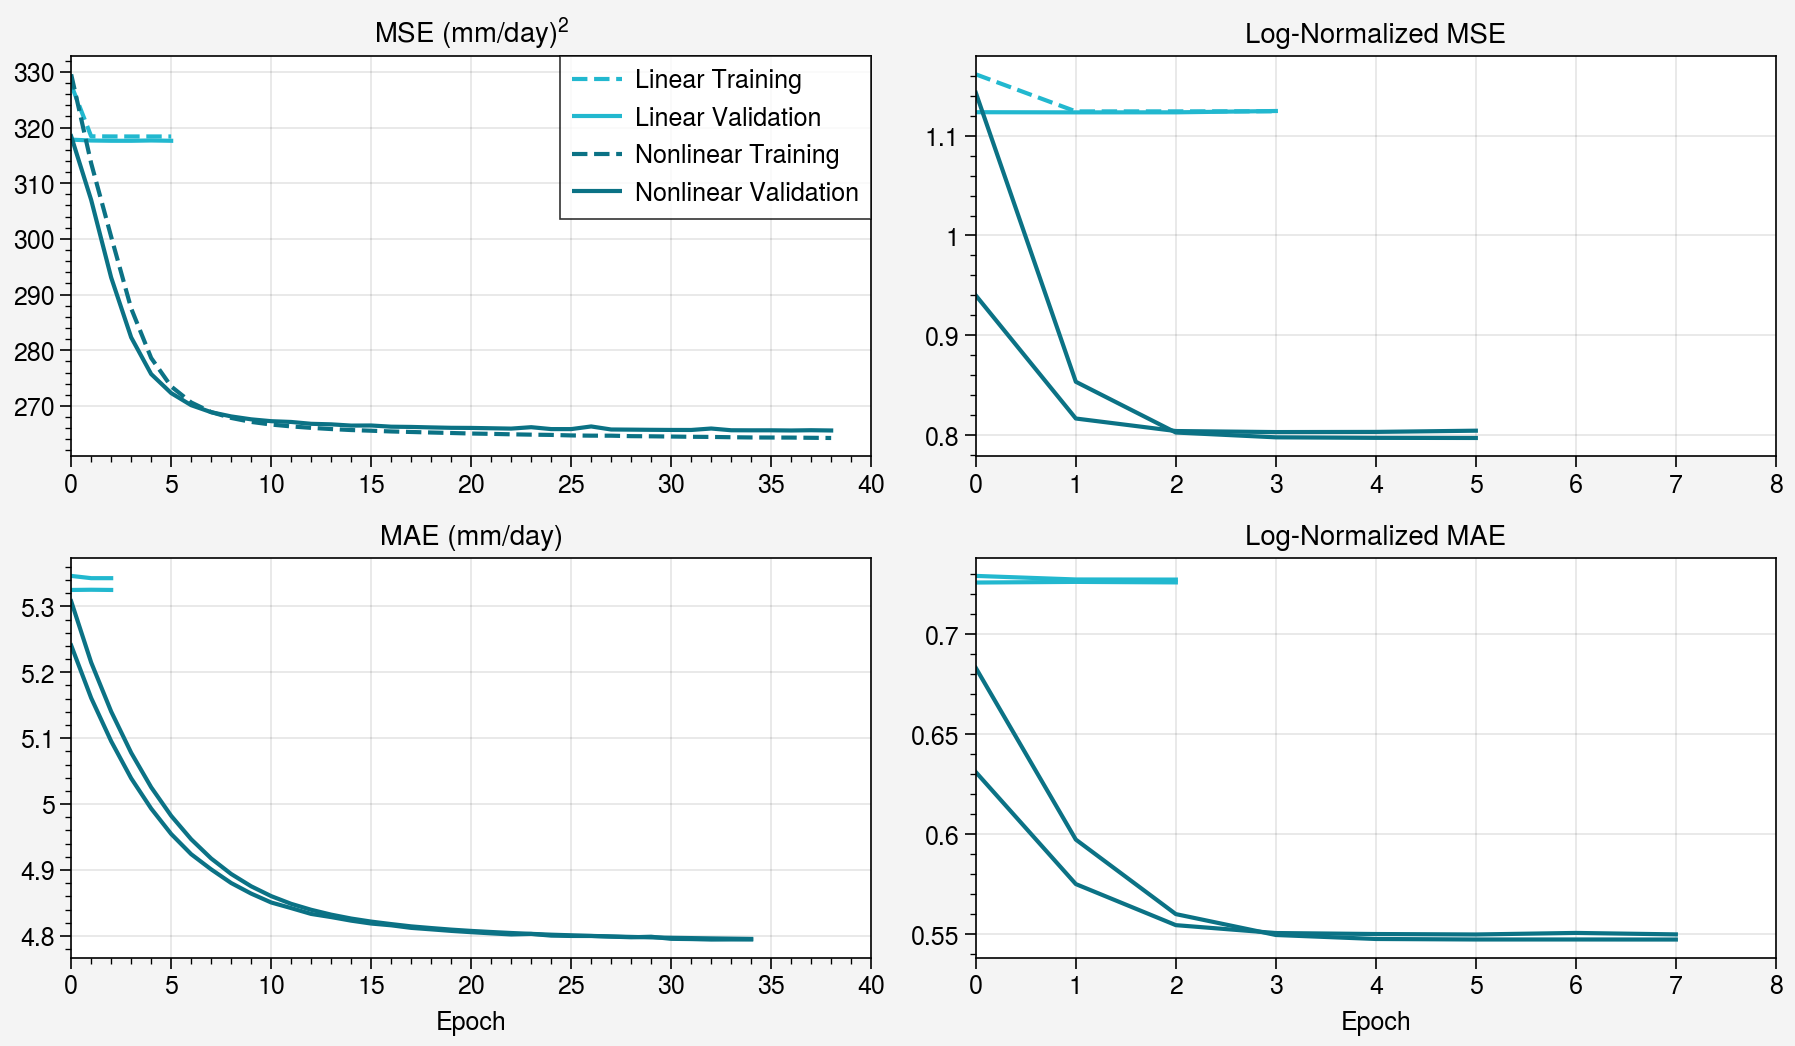

In [284]:
fig,axs = pplt.subplots(nrows=2,ncols=2,refwidth=4,refheight=2,sharex=False,sharey=False)
axs[1,:].format(xlabel='Epoch')
axs[:,0].format(xlim=(0,40))
axs[:,1].format(xlim=(0,8),xminorticks='none')
axs[0].format(title='MSE (mm/day)$^2$',yticks=10),
axs[1].format(title='Log-Normalized MSE',yticks=0.1)
axs[2].format(title='MAE (mm/day)',yticks=0.1)
axs[3].format(title='Log-Normalized MAE',yticks=0.05)

axs[0].plot(results['linear_mse']['trainlosses'],color='cyan5',linestyle='--',label='Linear Training')
axs[0].plot(results['linear_mse']['validlosses'],color='cyan5',label='Linear Validation')
axs[0].plot(results['relu_mse']['trainlosses'],color='cyan9',linestyle='--',label='Nonlinear Training')
axs[0].plot(results['relu_mse']['validlosses'],color='cyan9',label='Nonlinear Validation')

axs[1].plot(resultslog['linear_mse_log']['trainlosses'],color='cyan5',linestyle='--')
axs[1].plot(resultslog['linear_mse_log']['validlosses'],color='cyan5')
axs[1].plot(resultslog['relu_mse_log']['trainlosses'],color='cyan9')
axs[1].plot(resultslog['relu_mse_log']['validlosses'],color='cyan9')

axs[2].plot(results['linear_mae']['trainlosses'],color='cyan5')
axs[2].plot(results['linear_mae']['validlosses'],color='cyan5')
axs[2].plot(results['relu_mae']['trainlosses'],color='cyan9')
axs[2].plot(results['relu_mae']['validlosses'],color='cyan9')

axs[3].plot(resultslog['linear_mae_log']['trainlosses'],color='cyan5')
axs[3].plot(resultslog['linear_mae_log']['validlosses'],color='cyan5')
axs[3].plot(resultslog['relu_mae_log']['trainlosses'],color='cyan9')
axs[3].plot(resultslog['relu_mae_log']['validlosses'],color='cyan9')

axs[0].legend(loc='ur',ncols=1)
pplt.show()

In [194]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

def calc_metrics(ytrue,ypred):
    metrics = {}
    metrics['MSE']  = mean_squared_error(ytrue,ypred)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    metrics['MAE']  = mean_absolute_error(ytrue,ypred)
    metrics['R2']   = r2_score(ytrue,ypred)
    return metrics

In [209]:
allmetrics = {}
for modeldict in [results,resultslog]:
    for modelname,result in modeldict.items():
        ytrue = ytest['pr'].values
        if modeldict==results:
            ypred = result['testoutputs']
        elif modeldict==resultslog:
            ypred = inverse_log_normalize(result['testoutputs'],c=1.0)
        metrics = calc_metrics(ytrue,ypred)
        metrics['Title'] = result['description']
        allmetrics[modelname] = metrics
        
metricsdf = pd.DataFrame.from_dict(allmetrics,orient='index')
metricsdf

MSE       RMSE       MAE        R2  \
linear_mse      274.193268  16.558782  7.745236  0.051998   
linear_mae      313.990540  17.719778  5.245657 -0.085598   
relu_mse        226.399780  15.046587  5.508488  0.217241   
relu_mae        253.829712  15.932034  4.650370  0.122404   
linear_mse_log  296.966095  17.232704  5.297587 -0.026737   
linear_mae_log  314.174225  17.724961  5.243202 -0.086233   
relu_mse_log    258.416687  16.075344  4.702411  0.106545   
relu_mae_log    249.483170  15.795036  4.622582  0.137432   

                                 Title  
linear_mse                  Linear MSE  
linear_mae                  Linear MAE  
relu_mse                 Nonlinear MSE  
relu_mae                 Nonlinear MAE  
linear_mse_log     Log-Norm Linear MSE  
linear_mae_log     Log-Norm Linear MAE  
relu_mse_log    Log-Norm Nonlinear MSE  
relu_mae_log    Log-Norm Nonlinear MAE

Plot Types

- Barplot of Metric: ranks all models by chosen metric, find best model by metric
- Violin/Boxplot Error: distribution of prediction errors, check residuals and bias
- Scatter Plot (Pred vs True): fit quality and bias, see if model output is calibrated
- Heatmap/Table: full overview of all metrics, quick overall comparison
- Line Plot Multi-metric: trends for several metrics, per model	multi-metric optimization

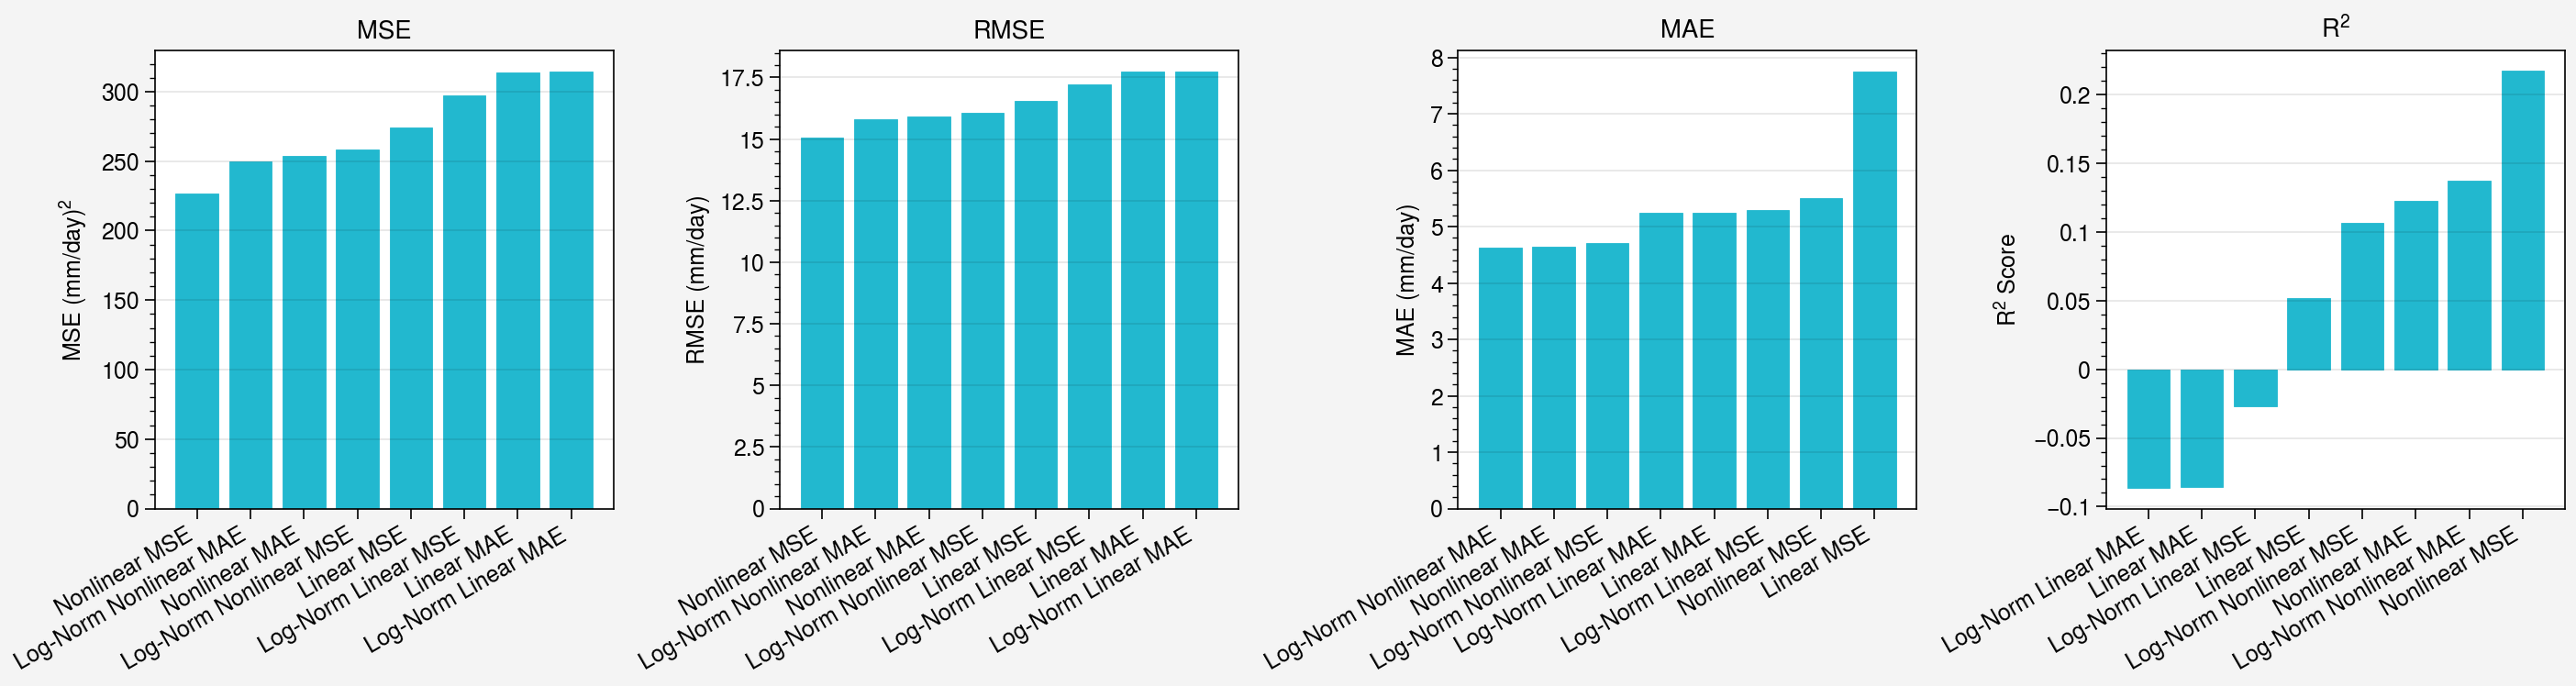

In [221]:
fig,axs = pplt.subplots(nrows=1,ncols=4,sharey=False)
axs.format(xlabel='',xrotation=30,xminorticks='none',xgrid=False)
axs[0].format(title='MSE',ylabel='MSE (mm/day)$^2$')
axs[1].format(title='RMSE',ylabel='RMSE (mm/day)')
axs[2].format(title='MAE',ylabel='MAE (mm/day)')
axs[3].format(title='R$^2$',ylabel='R$^2$ Score')

for i, metric in enumerate(['MSE','RMSE','MAE','R2']):
    sorteddf = metricsdf.sort_values(metric)
    axs[i].bar(sorteddf['Title'],sorteddf[metric],color='cyan5')

pplt.show()

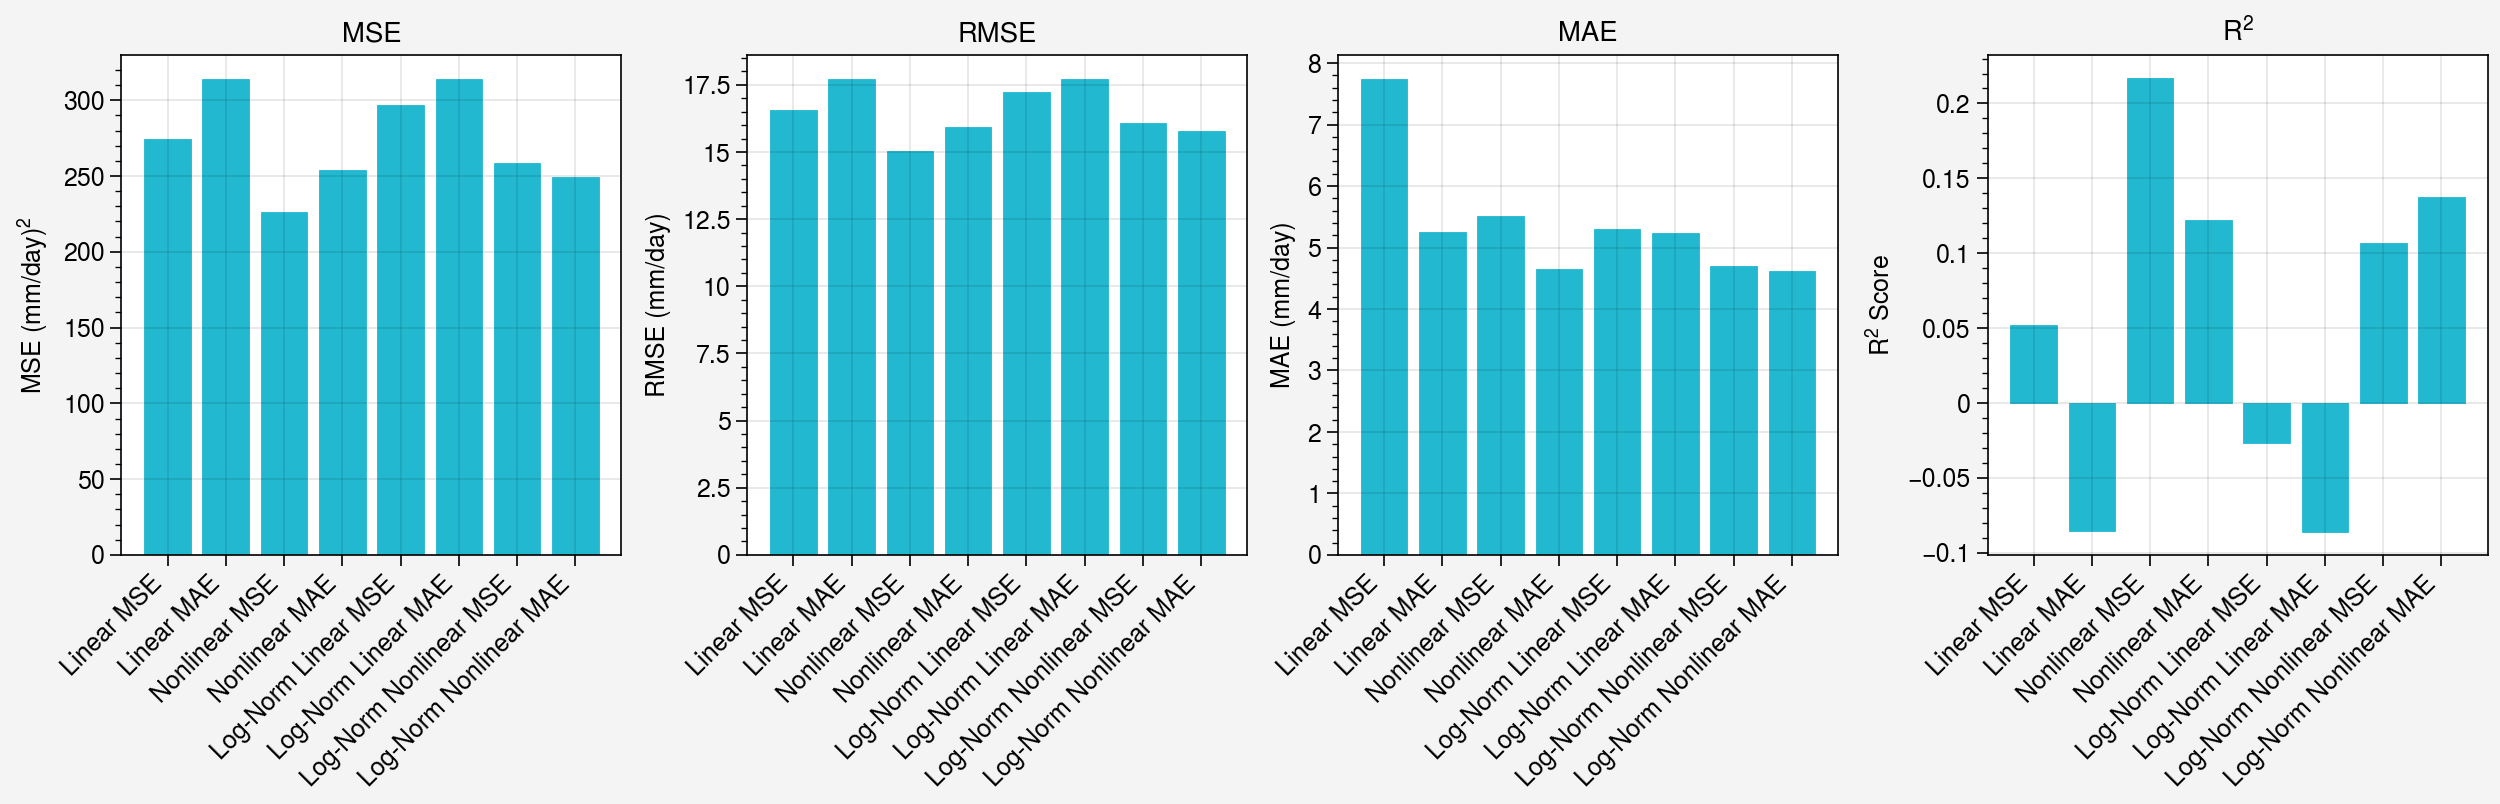

In [219]:
fig, axs = pplt.subplots(nrows=1, ncols=4, sharey=False)
axs.format(xlabel='', xrotation=45, xminorticks='none')
axs[0].format(title='MSE', ylabel='MSE (mm/day)$^2$')
axs[1].format(title='RMSE', ylabel='RMSE (mm/day)')
axs[2].format(title='MAE', ylabel='MAE (mm/day)')
axs[3].format(title='R$^2$', ylabel='R$^2$ Score')

for i, metric in enumerate(['MSE', 'RMSE', 'MAE', 'R2']):
    axs[i].bar(metricsdf['Title'], metricsdf[metric], color='cyan5')

pplt.show()

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

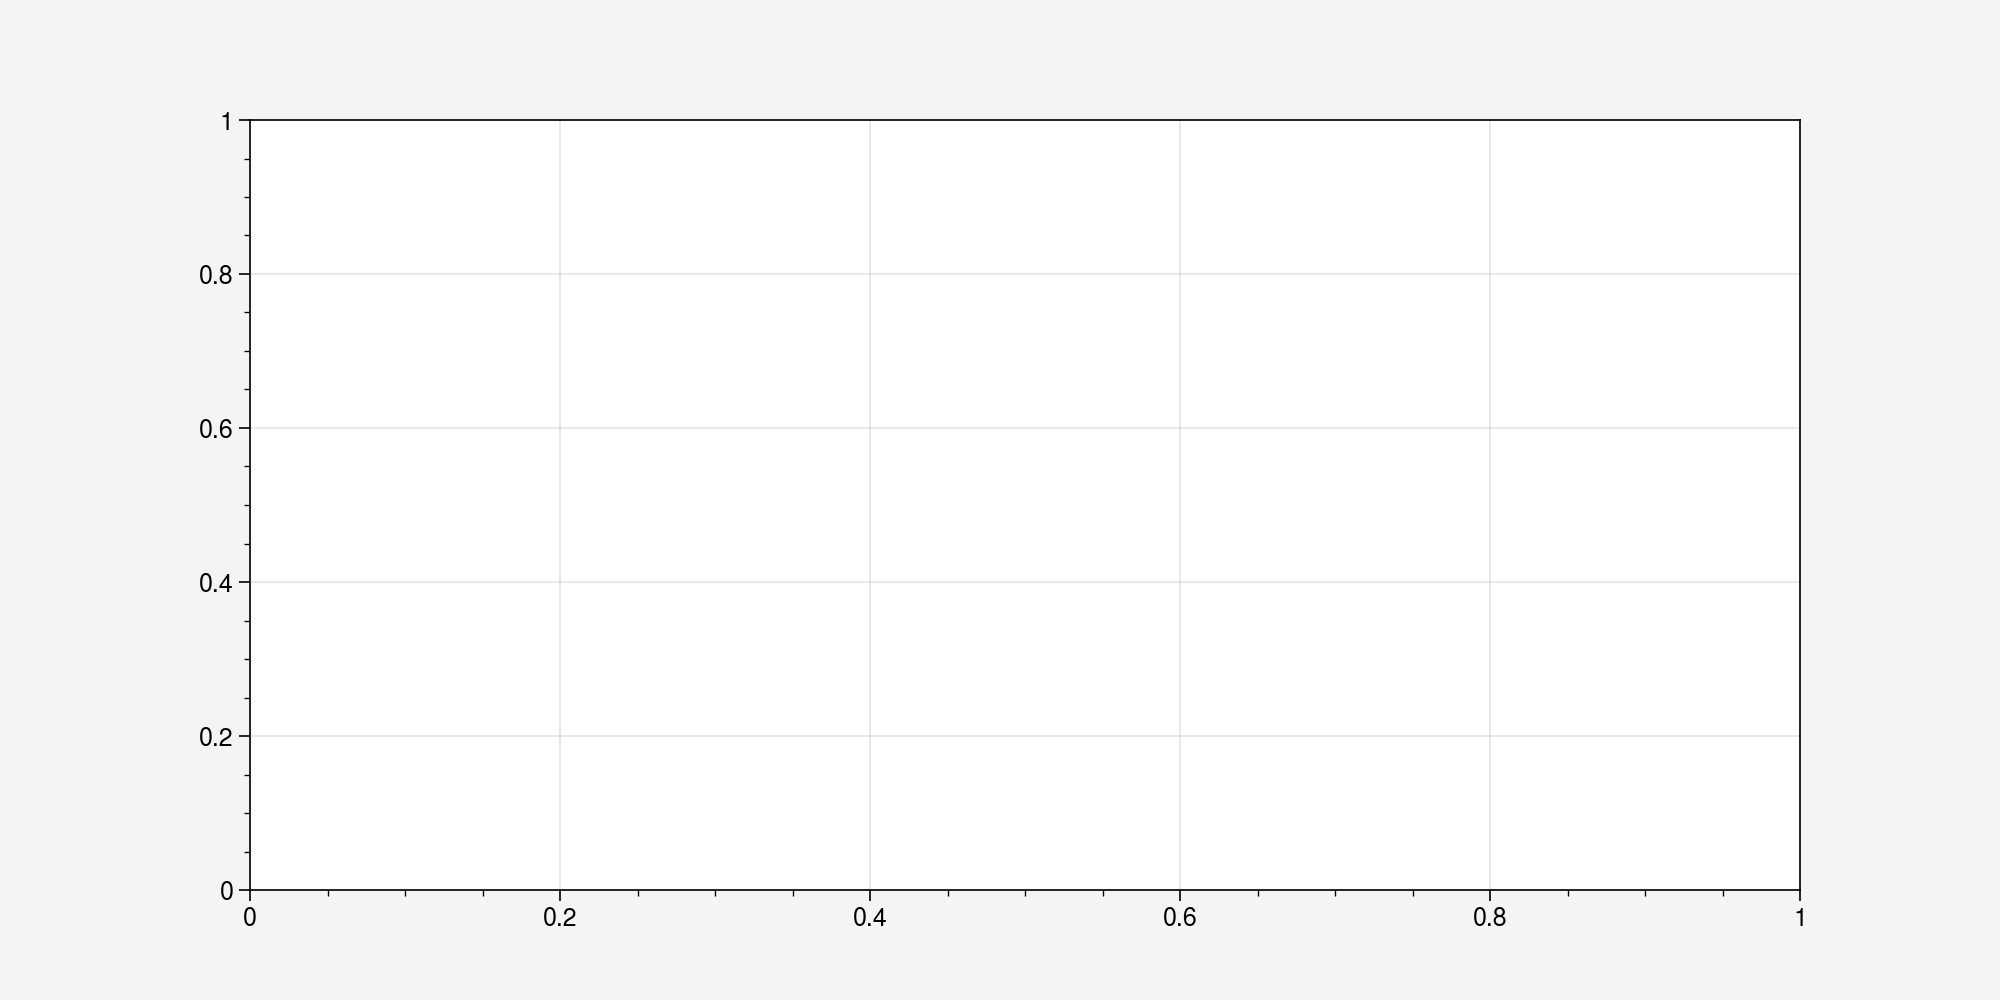

In [180]:
plt.figure(figsize=(10, 5))
plt.plot(metricsdf.index, metricsdf['RMSE'], marker='o', label='RMSE')
plt.plot(metricsdf.index, metricsdf['MAE'], marker='s', label='MAE')
plt.plot(metricsdf.index, metricsdf['MSE'], marker='d', label='MSE')
plt.plot(metricsdf.index, metricsdf['R2'], marker='x', label='R²')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Metric Value')
plt.xlabel('Model')
plt.title('Model Metrics Comparison')
plt.legend()
plt.tight_layout()
plt.show()

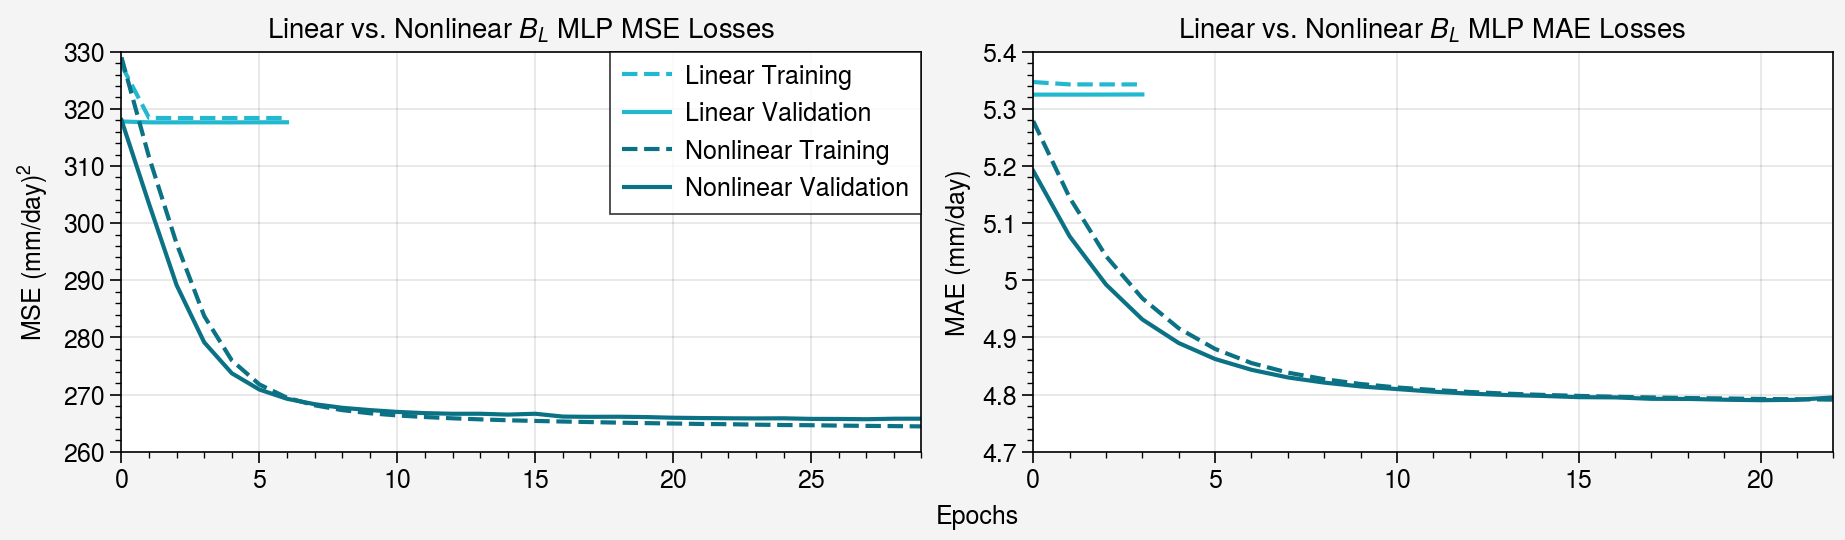

In [56]:
fig,axs = pplt.subplots(nrows=1,ncols=2,refwidth=4,refheight=2,sharex=True,sharey=False)
axs.format(xlabel='Epochs',xticks=5)
axs[0].plot(results['linear_mse']['trainlosses'],color='cyan5',linestyle='--',label='Linear Training')
axs[0].plot(results['linear_mse']['validlosses'],color='cyan5',label='Linear Validation')
axs[0].plot(results['relu_mse']['trainlosses'],color='cyan9',linestyle='--',label='Nonlinear Training')
axs[0].plot(results['relu_mse']['validlosses'],color='cyan9',label='Nonlinear Validation')
axs[0].format(title='Linear vs. Nonlinear $\mathit{B_L}$ MLP MSE Losses ',ylabel='MSE (mm/day)$^2$',ylim=(260,330))
axs[1].plot(results['linear_mae']['trainlosses'],color='cyan5',linestyle='--',label='Linear Training')
axs[1].plot(results['linear_mae']['validlosses'],color='cyan5',label='Linear Validation')
axs[1].plot(results['relu_mae']['trainlosses'],color='cyan9',linestyle='--',label='Nonlinear Training')
axs[1].plot(results['relu_mae']['validlosses'],color='cyan9',label='Nonlinear Validation')
axs[1].format(title='Linear vs. Nonlinear $\mathit{B_L}$ MLP MAE Losses ',ylabel='MAE (mm/day)',ylim=(4.7,5.4))
axs[0].legend(loc='ur',ncols=1)
pplt.show()

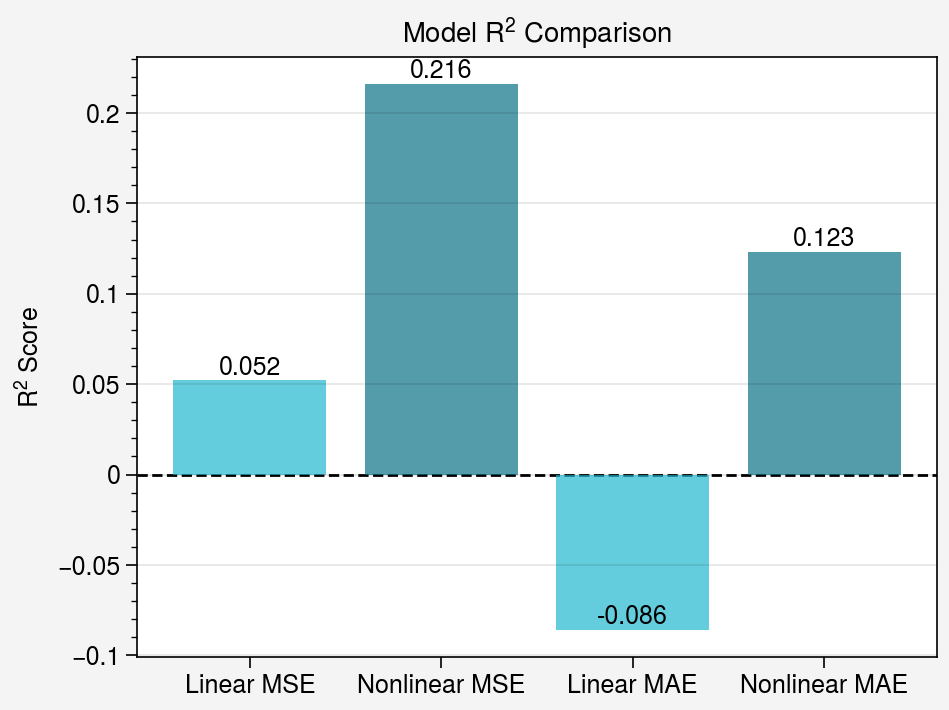

In [75]:
r2scores = {}
for modelname,result in results.items():
    ytrue = ytest['pr'].values.flatten()
    ypred = result['testoutputs'].flatten()
    r2scores[modelname] = r2_score(ytrue,ypred)

models   = ['linear_mse','relu_mse', 'linear_mae', 'relu_mae']
r2values = [r2scores[model] for model in models]
colors   = ['cyan5','cyan9','cyan5','cyan9']

fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=4,refheight=3)
ax.format(title='Model R$^2$ Comparison',xgrid=False,xticks=range(len(models)),
          xticklabels=['Linear MSE','Nonlinear MSE','Linear MAE','Nonlinear MAE'],xminorticks='none',
          ylabel='R$^2$ Score',ygrid=True)
ax.axhline(y=0,color='k',linestyle='--',linewidth=1,zorder=0)
bars = ax.bar(range(len(models)),r2values,color=colors,alpha=0.7)
for i,(bar,r2) in enumerate(zip(bars,r2values)):
    ax.text(bar.get_x()+bar.get_width()/2,bar.get_height(),f'{r2:.3f}',ha='center',va='bottom')
pplt.show()

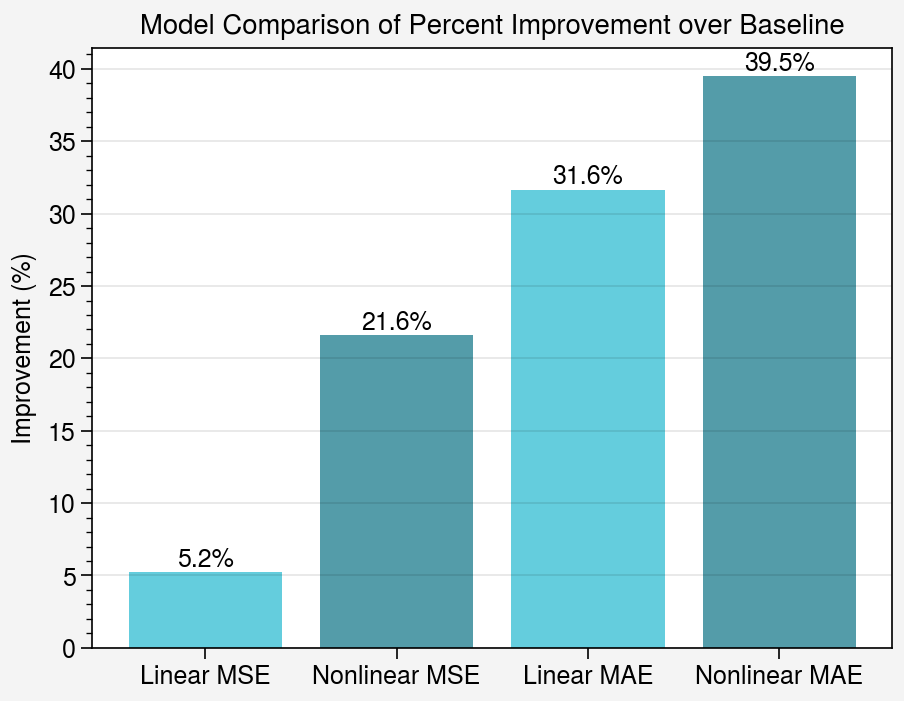

In [74]:
baselinemse = np.mean((ytest['pr'].values-np.mean(ytrain['pr'].values))**2)
baselinemae = np.mean(np.abs(ytest['pr'].values-np.mean(ytrain['pr'].values)))

improvements = {}
for modelname,result in results.items():
    if 'mse' in modelname:
        baseline = baselinemse
    else:
        baseline = baselinemae
    improvement = (baseline-result['testloss'])/baseline*100
    improvements[modelname] = improvement

models       = ['linear_mse','relu_mse','linear_mae','relu_mae']
improvvalues = [improvements[model] for model in models]
colors       = ['cyan5','cyan9','cyan5','cyan9']

fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=4,refheight=3)
ax.format(title='Model Comparison of Percent Improvement over Baseline',xgrid=False,xticks=range(len(models)),
          xticklabels=['Linear MSE','Nonlinear MSE','Linear MAE','Nonlinear MAE'],xminorticks='none',
          ylabel='Improvement (%)',ygrid=True)
bars = ax.bar(range(len(models)),improvvalues,color=colors,alpha=0.7)
for i,(bar,improv) in enumerate(zip(bars,improvvalues)):
    ax.text(bar.get_x()+bar.get_width()/2,bar.get_height(),f'{improv:.1f}%',ha='center',va='bottom')
pplt.show()

In [76]:
# Calculate both MSE and MAE for all models regardless of training loss
evaluation_metrics = {}
for model_name, result in results.items():
    y_true = ytest['pr'].values.flatten()
    y_pred = result['testoutputs'].flatten()
    
    # Calculate both metrics for all models
    mse_score = np.mean((y_true - y_pred)**2)
    mae_score = np.mean(np.abs(y_true - y_pred))
    r2_score_val = r2_score(y_true, y_pred)
    
    evaluation_metrics[model_name] = {
        'MSE': mse_score,
        'MAE': mae_score,
        'R2': r2_score_val
    }

# Create comparison table
print(f"{'Model':<15} {'MSE':<10} {'MAE':<10} {'R²':<10}")
print("-" * 50)
for model_name in ['linear_mse', 'relu_mse', 'linear_mae', 'relu_mae']:
    metrics = evaluation_metrics[model_name]
    print(f"{model_name:<15} {metrics['MSE']:<10.4f} {metrics['MAE']:<10.4f} {metrics['R2']:<10.3f}")

Model           MSE        MAE        R²        
--------------------------------------------------
linear_mse      274.1814   7.7141     0.052     
relu_mse        226.7591   5.5456     0.216     
linear_mae      314.0322   5.2460     -0.086    
relu_mae        253.6376   4.6441     0.123     


In [78]:
class HuberLoss(torch.nn.Module):
    def __init__(self,delta=1.0):
        super(HuberLoss,self).__init__()
        self.delta = delta
    def forward(self,inputs,targets):
        return torch.nn.functional.huber_loss(inputs,targets,delta=self.delta)

huberconfigs = [
    {'name':'huber_0.5','criterion':HuberLoss(delta=0.5)},
    {'name':'huber_1.0','criterion':HuberLoss(delta=1.0)},
    {'name':'huber_2.0','criterion':HuberLoss(delta=2.0)},
]

torch.nn.SmoothL1Loss(beta=1.0)  # Try different beta values

class QuantileLoss(torch.nn.Module):
    def __init__(self, quantile=0.5):
        super(QuantileLoss, self).__init__()
        self.quantile = quantile
    
    def forward(self, input, target):
        errors = target - input
        return torch.mean(torch.max(self.quantile * errors, (self.quantile - 1) * errors))

# Different quantiles
quantile_configs = [
    {'name': 'quantile_0.3', 'criterion': QuantileLoss(0.3)},  # Penalizes overestimation more
    {'name': 'quantile_0.7', 'criterion': QuantileLoss(0.7)},  # Penalizes underestimation more
]

class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super(LogCoshLoss, self).__init__()
    
    def forward(self, input, target):
        diff = input - target
        return torch.mean(torch.log(torch.cosh(diff)))

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, input, target):
        mse = torch.nn.functional.mse_loss(input, target, reduction='none')
        pt = torch.exp(-mse)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * mse
        return torch.mean(focal_loss)

class AsymmetricLoss(torch.nn.Module):
    def __init__(self, over_penalty=1.0, under_penalty=2.0):
        super(AsymmetricLoss, self).__init__()
        self.over_penalty = over_penalty
        self.under_penalty = under_penalty
    
    def forward(self, input, target):
        errors = input - target
        over_pred = torch.where(errors > 0, errors, torch.zeros_like(errors))
        under_pred = torch.where(errors < 0, -errors, torch.zeros_like(errors))
        return torch.mean(self.over_penalty * over_pred + self.under_penalty * under_pred)

In [79]:
# Extended configurations to test
extended_configurations = [
    # Original models
    {'name': 'linear_mse', 'activation': torch.nn.Identity(), 'criterion': torch.nn.MSELoss()},
    {'name': 'linear_mae', 'activation': torch.nn.Identity(), 'criterion': torch.nn.L1Loss()},
    {'name': 'relu_mse', 'activation': torch.nn.ReLU(), 'criterion': torch.nn.MSELoss()},
    {'name': 'relu_mae', 'activation': torch.nn.ReLU(), 'criterion': torch.nn.L1Loss()},
    
    # New loss functions
    {'name': 'relu_huber_1.0', 'activation': torch.nn.ReLU(), 'criterion': HuberLoss(delta=1.0)},
    {'name': 'relu_huber_2.0', 'activation': torch.nn.ReLU(), 'criterion': HuberLoss(delta=2.0)},
    {'name': 'relu_smooth_l1', 'activation': torch.nn.ReLU(), 'criterion': torch.nn.SmoothL1Loss()},
    {'name': 'relu_logcosh', 'activation': torch.nn.ReLU(), 'criterion': LogCoshLoss()},
    {'name': 'relu_quantile_0.7', 'activation': torch.nn.ReLU(), 'criterion': QuantileLoss(0.7)},
    {'name': 'relu_asymmetric', 'activation': torch.nn.ReLU(), 'criterion': AsymmetricLoss(over_penalty=1.0, under_penalty=1.5)},
]

# Evaluate all models with multiple metrics
def comprehensive_evaluation(results):
    metrics = ['MSE', 'MAE', 'RMSE', 'R2', 'MedAE']
    
    for model_name, result in results.items():
        y_true = ytest['pr'].values.flatten()
        y_pred = result['testoutputs'].flatten()
        
        print(f"\n{model_name}:")
        print(f"  MSE: {np.mean((y_true - y_pred)**2):.4f}")
        print(f"  MAE: {np.mean(np.abs(y_true - y_pred)):.4f}")
        print(f"  RMSE: {np.sqrt(np.mean((y_true - y_pred)**2)):.4f}")
        print(f"  R²: {r2_score(y_true, y_pred):.4f}")
        print(f"  Median AE: {np.median(np.abs(y_true - y_pred)):.4f}")

In [80]:
comprehensive_evaluation(results)


linear_mse:
  MSE: 274.1814
  MAE: 7.7141
  RMSE: 16.5584
  R²: 0.0520
  Median AE: 5.5554

linear_mae:
  MSE: 314.0322
  MAE: 5.2460
  RMSE: 17.7210
  R²: -0.0857
  Median AE: 0.2663

relu_mse:
  MSE: 226.7591
  MAE: 5.5456
  RMSE: 15.0585
  R²: 0.2160
  Median AE: 1.3810

relu_mae:
  MSE: 253.6376
  MAE: 4.6441
  RMSE: 15.9260
  R²: 0.1231
  Median AE: 0.3172


In [13]:
baseline = BASELINE(
    binwidth=0.002,
    binmin=-0.6,
    binmax=0.1,
    samplethresh=50,
    criterion=torch.nn.MSELoss())

baselinemodel   = baseline.fit(xtrain['bl'].values,ytrain['pr'].values)
baselineoutputs = baseline.predict(xtest['bl'].values)
baselineloss    = baseline.evaluate(xtest['bl'].values,ytest['pr'].values)

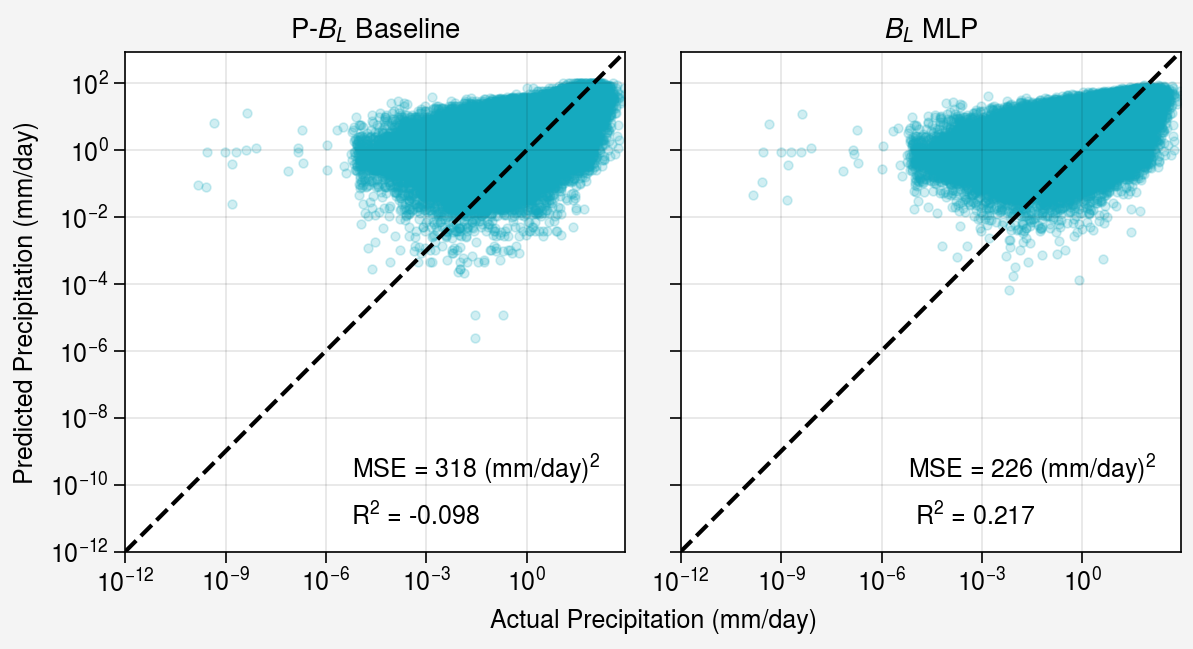

In [49]:
def r2_from_mse(mse,targets):
    ssres = mse*len(targets)
    sstot = np.sum((targets-np.mean(targets))**2)
    r2 = 1-(ssres/sstot)
    return r2

fig,axs = pplt.subplots(nrows=1,ncols=2)
axs.format(xlabel='Actual Precipitation (mm/day)',xscale='log',xformatter='log',ylabel='Predicted Precipitation (mm/day)',yscale='log',yformatter='log')
axs[0].format(title='P-$\mathit{B_L}$ Baseline')
axs[1].format(title='$\mathit{B_L}$ MLP')
axmin = max(1e-12,min(ytest['pr'].min(),baselineoutputs.min(),mlpoutputs.min()))
axmax = max(ytest['pr'].max(),baselineoutputs.max(),mlpoutputs.max())
for ax,outputs,mse in zip(axs,[baselineoutputs,mlpoutputs],[baselineloss,mlploss]):
    targets = ytest['pr'].values
    r2 = r2_from_mse(mse,targets)
    ax.scatter(targets,outputs,color='cyan6',markersize=10,alpha=0.2)
    line = np.logspace(np.log10(axmin),np.log10(axmax),num=100)
    ax.plot(line,line,'k--',linewidth=1.5)  
    ax.format(xlim=(axmin,axmax),ylim=(axmin,axmax))
    ax.text(0.95,0.2,f'MSE = {mse:.0f} (mm/day)$^2$',transform=ax.transAxes,va='top',ha='right')
    ax.text(0.71,0.1,f'R$^2$ = {r2:.3f}',transform=ax.transAxes,va='top',ha='right')
pplt.show()

In [127]:
def custom_loss_functions():
    
    def mse_loss(ytrue,ypred):
        return np.mean((ytrue-ypred)**2)
    
    def mae_loss(ytrue,ypred):
        return np.mean(np.abs(ytrue-ypred))
    
    def rmse_loss(ytrue,ypred):
        return np.sqrt(np.mean((ytrue-ypred)**2))
    
    def huber_loss(ytrue,ypred,delta=1.0):
        residual = np.abs(ytrue-ypred)
        return np.mean(np.where(residual<=delta,0.5*residual**2, delta*(residual-0.5*delta)))
    
    def log_cosh_loss(ytrue,ypred):
        return np.mean(np.log(np.cosh(ypred-ytrue)))
    
    def quantile_loss(ytrue,ypred,quantile=0.5):
        residual = ytrue-ypred
        return np.mean(np.maximum(quantile*residual,(quantile-1)*residual))
    
    return {
        'MSE':mse_loss,
        'MAE':mae_loss, 
        'RMSE':rmse_loss,
        'Huber':huber_loss,
        'LogCosh':log_cosh_loss,
        'Quantile_50':lambda ytrue,ypred:quantile_loss(ytrue,ypred,0.5),
        'Quantile_90':lambda ytrue,ypred:quantile_loss(ytrue,ypred,0.9)}